# Module Initialization
Here we will load all data and relevant modules. This will access helpful utilities aswell.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from utils.utils import *
from nn.rnn import *
import torch, torchaudio, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
#for macOS
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [ ]:
X_test = np.load(add_path("X_test.npy"))
y_test = np.load(add_path("y_test.npy"))
person_train_valid = np.load(add_path("person_train_valid.npy"))
X_train_valid = np.load(add_path("X_train_valid.npy"))
y_train_valid = np.load(add_path("y_train_valid.npy"))
person_test = np.load(add_path("person_test.npy"))

Check the shape of our data

In [3]:
print('Training/Valid data shape: {}'.format(X_train_valid.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Training/Valid Target shape: {}'.format(y_train_valid.shape))
print('Test Target shape: {}'.format(y_test.shape))
print('Person Train/Valid shape: {}'.format(person_train_valid.shape))
print('Person Test shape: {}'.format(person_test.shape))
print(y_train_valid)

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid Target shape: (2115,)
Test Target shape: (443,)
Person Train/Valid shape: (2115, 1)
Person Test shape: (443, 1)
[771 772 769 ... 772 772 771]


# Data Preprocessing

Here we will perfrom some data preprocessing to create a larger dataset and improve the generalization of our network.

## Outline
**Describe the preprocessing that will be done**

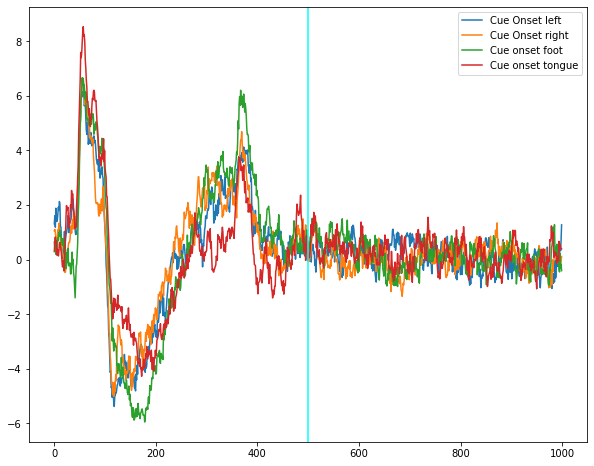

In [4]:
y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [5]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [6]:
# to_categorical is a tensorflow command so here it is in python
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [7]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
x_test, y_test = data_prep(X_test,y_test,2,2,True)

print("shapes")
print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(x_test.shape)
print(y_test.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 5000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# # Reshaping the training and validation dataset

# x_train = np.swapaxes(x_train, 1,2)
# x_valid = np.swapaxes(x_valid, 1,2)
# x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)

# change to tensor
x_train = Variable(torch.Tensor(x_train))
x_valid = Variable(torch.Tensor(x_valid))
x_test = Variable(torch.Tensor(x_test))

y_train = Variable(torch.Tensor(y_train))
y_train = torch.reshape(y_train,  (y_train.shape[0], 1)) 

y_valid = Variable(torch.Tensor(y_valid))
y_valid = torch.reshape(y_valid,  (y_valid.shape[0], 1)) 

y_test = Variable(torch.Tensor(y_test))
y_test = torch.reshape(y_test, (y_test.shape[0], 1))
print("")
print('final shape')
print("Training Shape", x_train.shape, y_train.shape)
print("Valid Shape", x_valid.shape, y_valid.shape)
print("Test Shape", x_test.shape, y_test.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
shapes
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (3460, 22, 250)
Shape of validation set: (5000, 22, 250)
Shape of training labels: (3460,)
Shape of validation labels: (5000,)

final shape
Training Shape torch.Size([3460, 22, 250]) torch.Size([3460, 1])
Valid Shape torch.Size([5000, 22, 250]) torch.Size([5000, 1])
Test Shape torch.Size([1772, 22, 250]) torch.Size([1772, 1])


In [8]:
#Possible augmentations
# Create Data set with gaussian noise
std_data = np.std(X_train_valid)
X_train_valid_gn = np.random.randn(*X_train_valid.shape)*std_data/10 +X_train_valid

# Create data set with single sample shift
X_train_valid_delay = np.roll(X_train_valid,1,axis=2)

# Create data set that is scaled 
X_train_valid_half = X_train_valid/2

# RNN Hyperparameter Tuning

# Structure


In [9]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [10]:
num_epochs = 4 #epochs 
learning_rate = 0.001 #0.001 lr

input_size = 250 #number of features 
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers 

num_classes = 4 #number of output classes 
batch_size = 64 

In [ ]:
# Create Torch Itterables
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)
test_dataset  = torch.utils.data.TensorDataset(x_test, y_test)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1])
criterion = torch.nn.CrossEntropyLoss()   # CE Loss is our softmax
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
for epoch in range(num_epochs):
  for i, data in enumerate(trainloader,0):
    inputs,labels = data
    outputs = lstm1.forward(inputs) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
    loss = criterion(outputs, labels.reshape(labels.size(0),).type(torch.long))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop

  scheduler.step()
  print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  correct = 0
  total = 0
  with torch.no_grad():
    for data in validloader:
        inputs, labels = data
        outputs = lstm1(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.reshape(labels.size(0),)).sum().item()
  print("  Val Accuracy: %1.5f"% (float(correct) / float(total)))

In [ ]:
#test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = lstm1(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.reshape(labels.size(0),)).sum().item()
    print("Test Accuracy: %1.5f"% (float(correct) / float(total)))

## Single Subject Classification

In [ ]:
# Set new parameters here for single subject classification
num_epochs = 20 #epochs 
learning_rate = 0.001 #0.001 lr

input_size = 250 #number of features 
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers 

num_classes = 4 #number of output classes 
batch_size = 64 

In [11]:
# Create tesnor for each subject and run individual subject through network 
#for validation and test accuracy
totalsub = 9
subject_validscores = []
subject_testscores = []
for sub in range(0, totalsub):
    train_dataset = torch.utils.data.TensorDataset(x_train[np.where(person_train_valid == sub)[0]], y_train[np.where(person_train_valid == sub)[0]])
    valid_dataset = torch.utils.data.TensorDataset(x_valid[np.where(person_train_valid == sub)[0]], y_valid[np.where(person_train_valid == sub)[0]])
    test_dataset  = torch.utils.data.TensorDataset(x_test[np.where(person_test == sub)[0]], y_test[np.where(person_test == sub)[0]])
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1])
    criterion = torch.nn.CrossEntropyLoss()   # CE Loss is our softmax
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader,0):
            inputs,labels = data
            outputs = lstm1.forward(inputs) #forward pass
            optimizer.zero_grad() #calculate the gradient, manually setting to 0
            loss = criterion(outputs, labels.reshape(labels.size(0),).type(torch.long))
  
            loss.backward() #calculates the loss of the loss function
  
            optimizer.step() #improve from loss, i.e backprop

        scheduler.step()
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

        valcorrect = 0
        valtotal = 0
        with torch.no_grad():
            for data in validloader:
                inputs, labels = data
                outputs = lstm1(inputs)
        # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                valtotal += labels.size(0)
                valcorrect += (predicted == labels.reshape(labels.size(0),)).sum().item()
        print("  Val Accuracy: %1.5f"% (float(valcorrect) / float(valtotal)))
    print("subject " + str(sub+1) + " validation accuracy: %1.5f"% (float(valcorrect) / float(valtotal)))
    subject_validscores.append(float(valcorrect)/float(valtotal))
    #test set
    testcorrect = 0
    testtotal = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = lstm1(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            testtotal += labels.size(0)
            testcorrect += (predicted == labels.reshape(labels.size(0),)).sum().item()
            subject_testscores.append(float(testcorrect)/float(testtotal))
    print("subject " + str(sub+1) + " test accuracy: %1.5f"% (float(testcorrect) / float(testtotal)))

Epoch: 0, loss: 1.38774
  Val Accuracy: 0.21519
Epoch: 1, loss: 1.30701
  Val Accuracy: 0.21519
Epoch: 2, loss: 1.26784
  Val Accuracy: 0.26160
Epoch: 3, loss: 1.23569
  Val Accuracy: 0.28270
Epoch: 4, loss: 1.19109
  Val Accuracy: 0.27426
Epoch: 5, loss: 1.16202
  Val Accuracy: 0.29114
Epoch: 6, loss: 1.11727
  Val Accuracy: 0.27426
Epoch: 7, loss: 1.04551
  Val Accuracy: 0.27848
Epoch: 8, loss: 1.01604
  Val Accuracy: 0.27848
Epoch: 9, loss: 0.94136
  Val Accuracy: 0.27426
Epoch: 10, loss: 0.88620
  Val Accuracy: 0.27426
Epoch: 11, loss: 0.83446
  Val Accuracy: 0.28692
Epoch: 12, loss: 0.79747
  Val Accuracy: 0.30380
Epoch: 13, loss: 0.73476
  Val Accuracy: 0.31224
Epoch: 14, loss: 0.71742
  Val Accuracy: 0.31646
Epoch: 15, loss: 0.71959
  Val Accuracy: 0.32068
Epoch: 16, loss: 0.64563
  Val Accuracy: 0.31646
Epoch: 17, loss: 0.62328
  Val Accuracy: 0.32489
Epoch: 18, loss: 0.57438
  Val Accuracy: 0.33333
Epoch: 19, loss: 0.54044
  Val Accuracy: 0.33333
subject 1 validation accuracy:

Epoch: 19, loss: 0.50254
  Val Accuracy: 0.35776
subject 8 validation accuracy: 0.35776
subject 8 test accuracy: 0.34000
Epoch: 0, loss: 1.40609
  Val Accuracy: 0.20346
Epoch: 1, loss: 1.32495
  Val Accuracy: 0.21645
Epoch: 2, loss: 1.23851
  Val Accuracy: 0.27273
Epoch: 3, loss: 1.20231
  Val Accuracy: 0.28139
Epoch: 4, loss: 1.17415
  Val Accuracy: 0.31602
Epoch: 5, loss: 1.10401
  Val Accuracy: 0.32900
Epoch: 6, loss: 1.04361
  Val Accuracy: 0.34199
Epoch: 7, loss: 0.98236
  Val Accuracy: 0.34632
Epoch: 8, loss: 0.92650
  Val Accuracy: 0.35931
Epoch: 9, loss: 0.88587
  Val Accuracy: 0.35498
Epoch: 10, loss: 0.82596
  Val Accuracy: 0.38095
Epoch: 11, loss: 0.77507
  Val Accuracy: 0.37662
Epoch: 12, loss: 0.70180
  Val Accuracy: 0.37662
Epoch: 13, loss: 0.67774
  Val Accuracy: 0.37662
Epoch: 14, loss: 0.60374
  Val Accuracy: 0.38095
Epoch: 15, loss: 0.56630
  Val Accuracy: 0.39394
Epoch: 16, loss: 0.59321
  Val Accuracy: 0.39394
Epoch: 17, loss: 0.55972
  Val Accuracy: 0.38961
Epoch: 

In [14]:
print(subject_validscores)
print(subject_testscores)

[0.3333333333333333, 0.3516949152542373, 0.3305084745762712, 0.3418803418803419, 0.3659574468085106, 0.3516949152542373, 0.35294117647058826, 0.3577586206896552, 0.3939393939393939]
[0.38, 0.36, 0.32, 0.26, 0.2978723404255319, 0.30612244897959184, 0.4, 0.34, 0.3617021276595745]
